In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib
from tensorflow import lite

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Molo17/dataset.zip

In [ ]:
data_dir = 'dataset'
data_dir = pathlib.Path(data_dir)
VALIDATION_SPLIT = 0.3
SEED = 100
BATCH_SIZE = 32
WIDTH = 250
IMG_SIZE = (WIDTH, WIDTH)

In [ ]:
'''from PIL import Image
import os

directory = r'dataset/Transformer'
c=1
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        im = Image.open(directory+'/'+filename)
        name='new_file_'+str(c)+'.jpeg'
        rgb_im = im.convert('RGB')
        rgb_im.save(directory+'/'+name)
        c+=1
        print(os.path.join(directory, filename))
        os.remove(directory+'/'+filename)
        continue
    else:
        continue'''

In [ ]:
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=VALIDATION_SPLIT, 
                                             seed=SEED, 
                                             subset='training')
validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=VALIDATION_SPLIT, 
                                             seed=SEED, 
                                             subset='validation')

Found 4038 files belonging to 6 classes.
Using 2827 files for training.
Found 4038 files belonging to 6 classes.
Using 1211 files for validation.


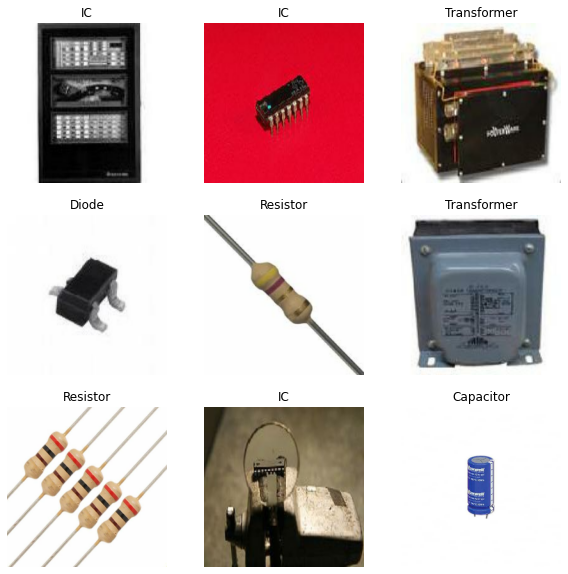

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

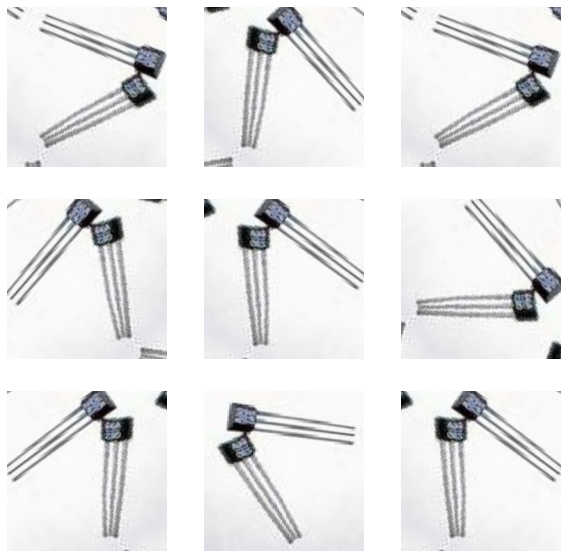

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 125, 125, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 125, 125, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 125, 125, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [ ]:
inputs = tf.keras.Input(shape=(WIDTH, WIDTH, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 250, 250, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

38/38 [==============================] - 60s 2s/step - loss: 1.8953 - sparse_categorical_accuracy: 0.2084


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.91
initial accuracy: 0.20


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
89/89 [==============================] - 216s 2s/step - loss: 1.6482 - sparse_categorical_accuracy: 0.3757 - val_loss: 1.4049 - val_sparse_categorical_accuracy: 0.5087
Epoch 2/10
89/89 [==============================] - 212s 2s/step - loss: 1.3998 - sparse_categorical_accuracy: 0.4708 - val_loss: 1.2129 - val_sparse_categorical_accuracy: 0.5830
Epoch 3/10
89/89 [==============================] - 211s 2s/step - loss: 1.2371 - sparse_categorical_accuracy: 0.5341 - val_loss: 1.0880 - val_sparse_categorical_accuracy: 0.6375
Epoch 4/10
89/89 [==============================] - 211s 2s/step - loss: 1.1205 - sparse_categorical_accuracy: 0.5939 - val_loss: 0.9957 - val_sparse_categorical_accuracy: 0.6664
Epoch 5/10
89/89 [==============================] - 211s 2s/step - loss: 1.0348 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.9336 - val_sparse_categorical_accuracy: 0.6912
Epoch 6/10
89/89 [==============================] - 212s 2s/step - loss: 0.9836 - sparse_categorical_accu

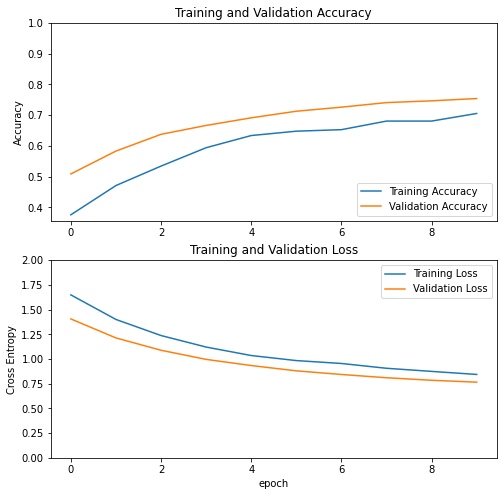

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(validation_dataset)

38/38 [==============================] - 59s 2s/step - loss: 0.7653 - sparse_categorical_accuracy: 0.7539


[0.7652719616889954, 0.7539224028587341]

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 250, 250, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
89/89 [==============================] - 301s 3s/step - loss: 0.8256 - sparse_categorical_accuracy: 0.7100 - val_loss: 0.7225 - val_sparse_categorical_accuracy: 0.7514
Epoch 11/20
89/89 [==============================] - 293s 3s/step - loss: 0.6854 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.6572 - val_sparse_categorical_accuracy: 0.7737
Epoch 12/20
89/89 [==============================] - 293s 3s/step - loss: 0.6441 - sparse_categorical_accuracy: 0.7830 - val_loss: 0.6132 - val_sparse_categorical_accuracy: 0.7878
Epoch 13/20
89/89 [==============================] - 293s 3s/step - loss: 0.6135 - sparse_categorical_accuracy: 0.7921 - val_loss: 0.5791 - val_sparse_categorical_accuracy: 0.7985
Epoch 14/20
89/89 [==============================] - 293s 3s/step - loss: 0.5746 - sparse_categorical_accuracy: 0.8016 - val_loss: 0.5611 - val_sparse_categorical_accuracy: 0.8134
Epoch 15/20
89/89 [==============================] - 298s 3s/step - loss: 0.5481 - sparse_categorica

In [ ]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

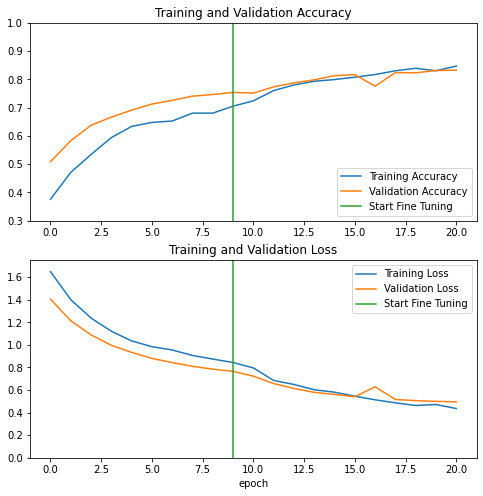

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.3, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.75])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [5 4 2 1 5 2 2 2 2 0 2 2 4 2 0 1 0 4 1 5 3 2 2 0 0 4 1 1 1 2 5 1]
Labels:
 [5 4 2 1 5 2 2 5 2 0 2 2 4 2 0 4 0 4 1 5 2 2 2 0 0 4 3 1 1 2 5 2]
Confidence:
 [78 69 98 94 94 93 91 70 99 93 97 98 96 70 94 54 67 99 82 99 80 84 56 86
 96 87 65 49 92 99 93 51]


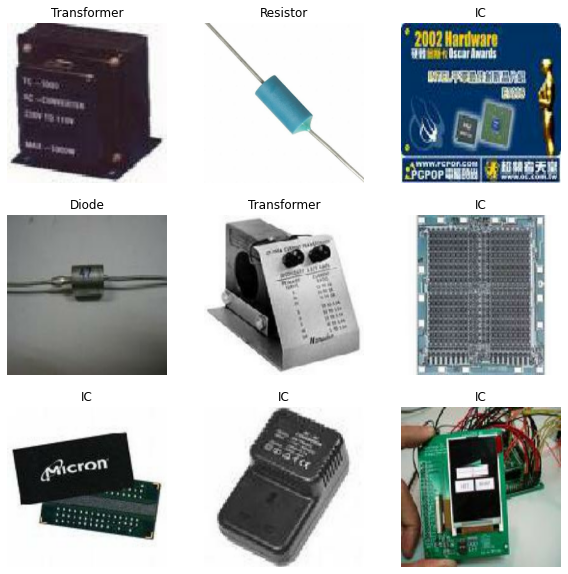

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
confidence = np.max(predictions, axis=1)
confidence = np.round(confidence*100).astype(int)
predictions = tf.math.argmax(predictions, axis=1).numpy()


print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
print('Confidence:\n', confidence)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ("mobilenet_v2_fine_tuned.tflite" , "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp1zrljz39/assets


8898116